In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor  # GPR モデル構築に使用
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct # カーネル関数に使用
from regression_tools import evaluate_performance_gpr, evaluate_model_gpr #自作モジュール
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
# ConvergenceWarningを無視する
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
#脱ブタン塔のプロセスデータを読み込む
df = pd.read_csv('debutanizer_data.csv')

#時系列データなので、実務データを想定しindexに時刻を割り当てる
# 開始日時を指定
start_datetime = '2024-01-01 00:00:00'
# DataFrameの長さを取得
n = len(df)
# 日時インデックスを生成（1分間隔）
date_index = pd.date_range(start=start_datetime, periods=n, freq='T')
# DataFrameのインデックスを新しい日時インデックスに設定
df.index = date_index

# 目的変数の測定時間を考慮（5分間）
df['y'] = df['y'].shift(5)

#yがnanとなる期間のデータを削除
df = df.dropna()

# 説明変数Xと目的変数yに分割
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#時間遅れ変数を作成
delay_number = 18
X_with_delays = pd.DataFrame()
for col in X.columns:
    col_name = f"{col}_delay_{delay_number}"
    X_with_delays[col_name] = X[col].shift(delay_number)

# 時間遅れ変数とｙのデータフレームを作成
X_with_delays['y'] = y
X_with_delays = X_with_delays.dropna()

# 目的変数と説明変数に分割
X = X_with_delays.iloc[:, :-1]
y = X_with_delays['y']

<ipython-input-3-3e8e6ae79e5b>:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_index = pd.date_range(start=start_datetime, periods=n, freq='T')


## ガウス過程回帰

In [5]:
def perform_gpr_regression_cross(X, y, fold_number=5, test_size=0.4, shuffle=False):
    """
    ガウス過程回帰モデルを構築し、クロスバリデーションを用いて最適なカーネルを決定します。
    その後、最適なカーネルでモデルを再構築し、訓練データとテストデータの性能を評価します。

    Parameters:
    X : pd.DataFrame
        説明変数のデータセット
    y : pd.Series
        目的変数のデータ
    fold_number : int, optional
        クロスバリデーションで使用するフォールドの数 (default is 5)。
    test_size : float, optional
        データを分割する際のテストデータの割合 (default is 0.4)。
    shuffle : bool, optional
        データ分割時にデータをシャッフルするかどうか (時系列データを想定して、デフォルトはFalse)。

    Returns:
    なし
    """
    #データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle,
                                                        random_state=0)

    # カーネル 11 種類
    kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * RBF(np.ones(X_train.shape[1])) + WhiteKernel(),
            ConstantKernel() * RBF(np.ones(X_train.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

    # データの標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

    # クロスバリデーションによるカーネル関数の最適化
    cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
    r2cvs = [] # 空の list。カーネル関数ごとに、クロスバリデーション後の r2 を入れていきます
    for index, kernel in enumerate(kernels):
        print(index + 1, '/', len(kernels))
        model = GaussianProcessRegressor(alpha=0, kernel=kernel)
        estimated_y_in_cv = np.ndarray.flatten(cross_val_predict(model, X_train_scaled, y_train_scaled, cv=cross_validation))
        estimated_y_in_cv = estimated_y_in_cv * y_train.std(ddof=1) + y_train.mean()
        r2cvs.append(metrics.r2_score(y_train, estimated_y_in_cv))
    optimal_kernel_number = np.where(r2cvs == np.max(r2cvs))[0][0]  # クロスバリデーション後の r2 が最も大きいカーネル関数の番号
    optimal_kernel = kernels[optimal_kernel_number]  # クロスバリデーション後の r2 が最も大きいカーネル関数
    print('クロスバリデーションで選択されたカーネル関数の番号 :', optimal_kernel_number)
    print('クロスバリデーションで選択されたカーネル関数 :', optimal_kernel)

    # モデル構築
    gpr_model = GaussianProcessRegressor(alpha=0, kernel=optimal_kernel) # GPR モデルの宣言
    gpr_model.fit(X_train_scaled, y_train_scaled)  # モデル構築

    evaluate_model_gpr(X_train_scaled, y_train, X_test_scaled, y_test, model=gpr_model)

1 / 11
2 / 11
3 / 11
4 / 11
5 / 11
6 / 11
7 / 11
8 / 11
9 / 11
10 / 11
11 / 11
クロスバリデーションで選択されたカーネル関数の番号 : 4
クロスバリデーションで選択されたカーネル関数 : 1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1)
Evaluating Training Data
R^2: 0.998, RMSE: 0.007, MAE: 0.004


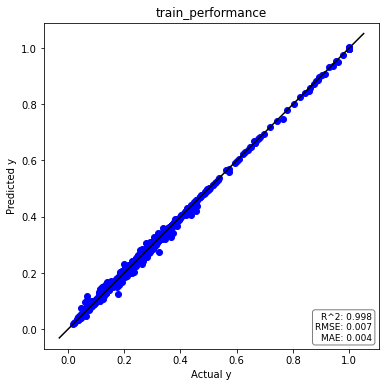

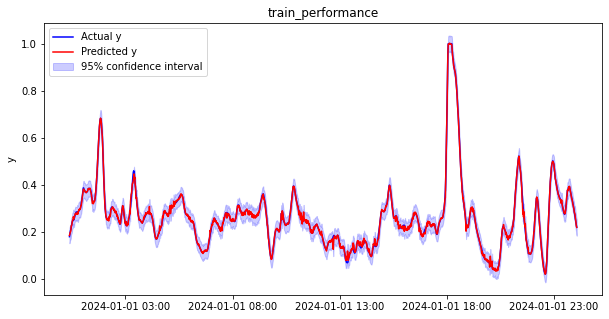

Evaluating Test Data
R^2: 0.548, RMSE: 0.123, MAE: 0.093


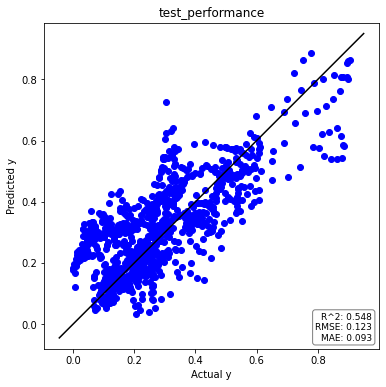

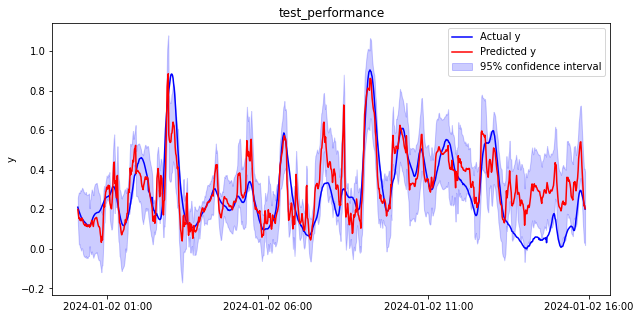

In [6]:
# 関数の実行
perform_gpr_regression_cross(X, y)